In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import math
import matplotlib.ticker as mticker

import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from scipy.stats import spearmanr
from scipy.stats import shapiro
from scipy.stats import anderson
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import datetime

from scipy import signal

import random
random.seed(1)

# Queries data

In [4]:
req_data_df=pd.read_csv('msk_spd_req_data.csv', index_col=[0], parse_dates=[4])
req_data_df

,request,abs number,rel number,date
0,сапсан москва санкт-петербург,34823.0,0.000015,2021-05-09
1,сапсан москва санкт-петербург,35908.0,0.000014,2021-05-16
2,сапсан москва санкт-петербург,39628.0,0.000015,2021-05-23
3,сапсан москва санкт-петербург,43068.0,0.000017,2021-05-30
4,сапсан москва санкт-петербург,48009.0,0.000019,2021-06-06
...,...,...,...,...
125,москва питер билеты,13994.0,0.000005,2022-04-03
126,москва питер билеты,16130.0,0.000006,2022-04-10
127,москва питер билеты,17379.0,0.000006,2022-04-17
128,москва питер билеты,17776.0,0.000006,2022-04-24


## Correlation analysis

In [4]:
stats.spearmanr(req_data_df.query('request=="сапсан москва санкт-петербург"')['abs number'], 
                req_data_df.query('request=="москва питер билеты"')['abs number'])

SpearmanrResult(correlation=0.8467514727226159, pvalue=2.5966177244998385e-15)

In [5]:
stats.spearmanr(req_data_df.query('request=="сапсан москва санкт-петербург"')['abs number'][:26], 
                req_data_df.query('request=="сапсан билеты"')['abs number'])

SpearmanrResult(correlation=0.9384615384615382, pvalue=1.418747624848629e-12)

In [6]:
stats.spearmanr(req_data_df.query('request=="москва питер билеты"')['abs number'][:26], 
                req_data_df.query('request=="сапсан билеты"')['abs number'])

SpearmanrResult(correlation=0.7777777777777777, pvalue=2.9247958509686215e-06)

In [15]:
req_simp_df=pd.pivot_table(req_data_df, values='abs number', index='request', columns='date')
req_simp_df.T.corr(method='spearman')

request,москва питер билеты,сапсан билеты,сапсан москва санкт-петербург
request,,,
москва питер билеты,1.000000,0.777778,0.846751
сапсан билеты,0.777778,1.000000,0.938462
сапсан москва санкт-петербург,0.846751,0.938462,1.000000


In [5]:
req_prep_simp_df=pd.pivot_table(req_data_df, values='abs number', index='request', columns='date')
res_req_df=pd.DataFrame(index=req_prep_simp_df.index, columns=req_prep_simp_df.loc['сапсан москва санкт-петербург'].resample('D').interpolate(method='linear').index)
for ind in req_prep_simp_df.index:
    res_req_df.loc[ind]=req_prep_simp_df.loc[ind].resample('D').interpolate(method='linear')
res_req_df

date,2021-05-09,2021-05-10,2021-05-11,2021-05-12,2021-05-13,2021-05-14,2021-05-15,2021-05-16,2021-05-17,2021-05-18,...,2022-04-22,2022-04-23,2022-04-24,2022-04-25,2022-04-26,2022-04-27,2022-04-28,2022-04-29,2022-04-30,2022-05-01
request,,,,,,,,,,,,,,,,,,,,,
москва питер билеты,10619.0,10601.285714,10583.571429,10565.857143,10548.142857,10530.428571,10512.714286,10495.0,10676.0,10857.0,...,17662.571429,17719.285714,17776.0,17955.857143,18135.714286,18315.571429,18495.428571,18675.285714,18855.142857,19035.0
сапсан билеты,28141.0,28204.857143,28268.714286,28332.571429,28396.428571,28460.285714,28524.142857,28588.0,29104.285714,29620.571429,...,21863.0,21863.0,21863.0,21863.0,21863.0,21863.0,21863.0,21863.0,21863.0,21863.0
сапсан москва санкт-петербург,34823.0,34978.0,35133.0,35288.0,35443.0,35598.0,35753.0,35908.0,36439.428571,36970.857143,...,51897.0,51510.0,51123.0,51117.857143,51112.714286,51107.571429,51102.428571,51097.285714,51092.142857,51087.0


# Total demand data

In [6]:
sum_demand_ser = pd.read_csv('total_demand.csv', index_col=['date'], parse_dates=['date'])
sum_demand_ser = pd.Series(sum_demand_ser.values.ravel(), index=sum_demand_ser.index)

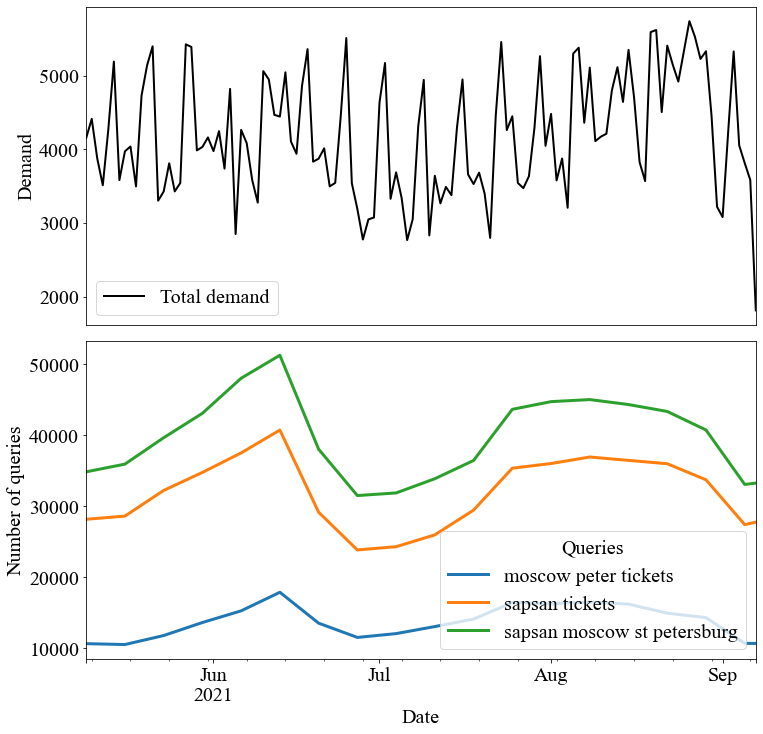

In [7]:
plt.rcParams['font.size'] = '20'
plt.rcParams['font.fantasy'] = 'Times New Roman'
plt.rcParams['font.family'] = 'fantasy'
fig, axes = plt.subplots(2, 1)
fig.set_size_inches(12, 12)
fig.subplots_adjust(wspace=0.3, hspace=0.05)
sum_demand_ser['2021-05-09':'2021-09-07'].plot(ax=axes[0], linewidth=2, color='k')
res_req_df.T['2021-05-09':'2021-09-07'].plot(ax=axes[1], linewidth=3)
axes[0].get_xaxis().set_visible(False)
axes[0].set_ylabel('Demand')
axes[0].legend(['Total demand'], loc='lower left')
axes[1].set_ylabel('Number of queries')
axes[1].set_xlabel('Date')
axes[1].legend(['moscow peter tickets', 'sapsan tickets', 'sapsan moscow st petersburg'], loc='lower right', title='Queries')

## Demand decomposition

In [8]:
result = seasonal_decompose(sum_demand_ser['2021-05-09':'2021-09-07'], model='multiplicative')

Text(0.5, 0, 'Date')

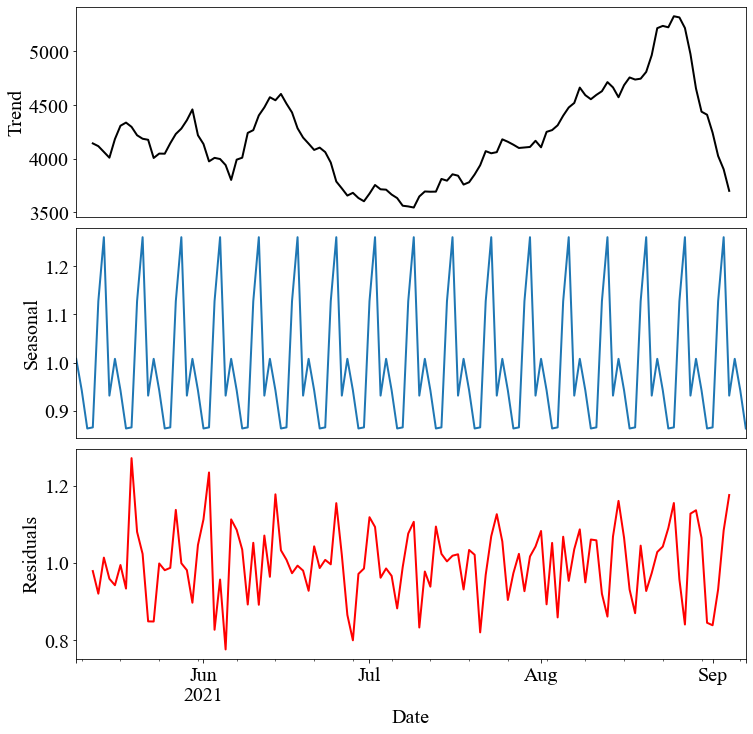

In [9]:
plt.rcParams['font.size'] = '20'
plt.rcParams['font.fantasy'] = 'Times New Roman'
plt.rcParams['font.family'] = 'fantasy'
fig, axes = plt.subplots(3, 1)
fig.subplots_adjust(wspace=0.3, hspace=0.05)
fig.set_size_inches(12, 12)
result.trend['2021-05-09':'2021-09-07'].plot(ax=axes[0], linewidth=2, color='k')
axes[0].get_xaxis().set_visible(False)
axes[1].get_xaxis().set_visible(False)
result.seasonal['2021-05-09':'2021-09-07'].plot(ax=axes[1], linewidth=2)
axes[0].set_ylabel('Trend')
axes[1].set_ylabel('Seasonal')
result.resid['2021-05-09':'2021-09-07'].plot(ax=axes[2], linewidth=2, color='r')
axes[2].set_ylabel('Residuals')
axes[2].set_xlabel('Date')

### Residual Analysis of the Multiplicative Model

Text(0, 0.5, 'Number')

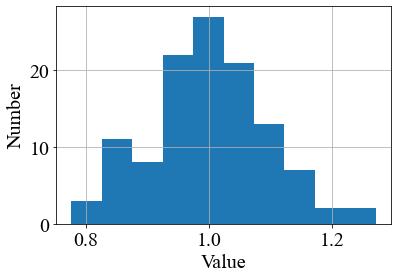

In [10]:
result.resid['2021-05-12':'2021-09-04'].hist()
plt.xlabel('Value')
plt.ylabel('Number')

#### Residual stationarity test
<br><font color=red>H0:</font> The time series has a unit root, it is non-stationary;
<br><font color=red>H1:</font> The time series does not have a unit root, it is stationary.

In [11]:
adfuller(result.resid['2021-05-12':'2021-09-04'])

(-7.86507893628933,
 5.16055552791405e-12,
 4,
 111,
 {'1%': -3.490683082754047,
  '5%': -2.8879516565798817,
  '10%': -2.5808574442009578},
 -221.35600514312318)

The <font color=red>H0</font> can be rejected with a confidence level of 0.99.

#### Test for the normal distribution of residuals

##### Shapiro-Wilk test
<br><font color=red>H0:</font> The data was drawn from a normal distribution;

In [12]:
stat, p = shapiro(result.resid['2021-05-12':'2021-09-04'])
stat, p

(0.9936441779136658, 0.8776935338973999)

The <font color=red>H0</font> can't be rejected with a confidence level of 0.95.

##### Anderson-Darling test
<br><font color=red>H0:</font> The data was drawn from a normal distribution;
<br><font color=red>H1:</font> The data was drawn from another distribution law.

In [13]:
anderson(result.resid['2021-05-12':'2021-09-04'], dist='norm')

AndersonResult(statistic=0.21181846354703282, critical_values=array([0.558, 0.635, 0.762, 0.889, 1.057]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

The <font color=red>H1</font> can be rejected with a confidence level of 0.99.

In [14]:
mu, sigma = result.resid['2021-05-12':'2021-09-04'].mean(), result.resid['2021-05-12':'2021-09-04'].std()

# Cross-correlation analysis

## Finding the best lag

In [15]:
cor_p = []
c_corr=list()
p_val=list()
coeffs_dict=dict()
lags_dict=dict()
p_val_dict=dict()
for ind in res_req_df.index:
    max_coeff = 0
    ind_coeff = 0
    p_v=0
    coeffs_list=list()
    lags_list=list()
    p_val_list=list()
    for i in range(31):
        if i != 0:
            coef_p, p_p = spearmanr(res_req_df.loc[ind][34-i:-239-i], result.trend['2021-06-12':'2021-09-04'])
            coeffs_list.append(coef_p)
            lags_list.append(i)
            p_val_list.append(p_p)
            if coef_p > max_coeff:
                max_coeff = coef_p
                ind_coeff = i
                p_v=p_p           
    coeffs_dict[ind]=coeffs_list
    lags_dict[ind]=lags_list
    p_val_dict[ind]=p_val_list    
    cor_p.append(ind_coeff)
    c_corr.append(max_coeff)
    p_val.append(p_v)
coeffs_df=pd.DataFrame(coeffs_dict)
lags_df=pd.DataFrame(lags_dict)
p_val_df=pd.DataFrame(p_val_dict)
print('Lag: ', cor_p)
print('corr: ', c_corr)
print('p_val: ', p_val)

Lag:  [4, 3, 3]
corr:  [0.757905022474106, 0.8651749071721712, 0.8016220441665038]
p_val:  [4.576032060965207e-17, 1.3262818207996498e-26, 3.0927512045024084e-20]


Text(0.5, -0.13, 'b.')

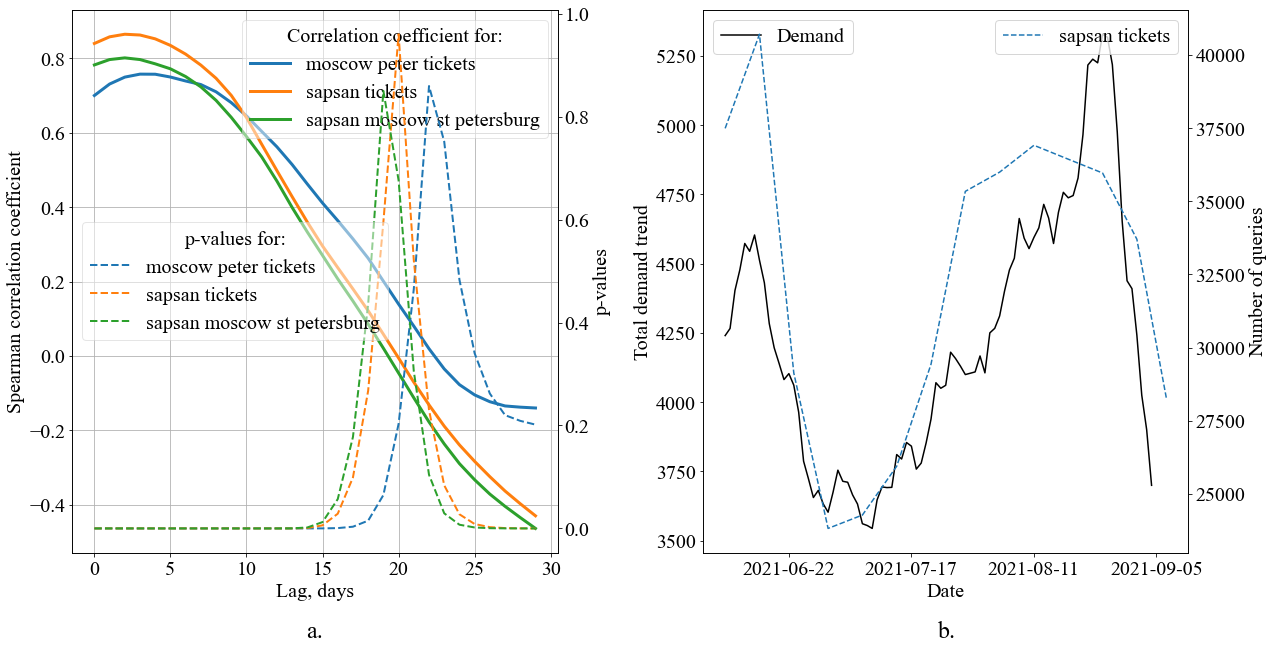

In [16]:
plt.rcParams['font.size'] = '20'
plt.rcParams['font.fantasy'] = 'Times New Roman'
plt.rcParams['font.family'] = 'fantasy'

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(20, 10)
fig.subplots_adjust(wspace=0.3, hspace=0.05)
ax0 = axes[0].twinx()
coeffs_df.plot(ax=axes[0], linewidth=3)
axes[0].set_ylabel('Spearman correlation coefficient')
axes[0].legend(['moscow peter tickets', 'sapsan tickets', 'sapsan moscow st petersburg'], title='Correlation coefficient for:', loc = "upper right", framealpha=0.5)
axes[0].set_xlabel('Lag, days')

p_val_df.plot(ax=ax0, linewidth=2, linestyle = '--')
ax0.set_ylabel('p-values')
ax0.legend(['moscow peter tickets', 'sapsan tickets', 'sapsan moscow st petersburg'], title='p-values for:', loc = 'center left', framealpha=0.5)
axes[0].grid(axis = 'both')
axes[0].set_title('a.', y=-0.13,pad=-14)

lag=3
req_name='сапсан билеты'

ax1 = axes[1].twinx()
ax1.plot(result.trend['2021-06-09':'2021-09-07'].index, res_req_df.loc[req_name][31-lag:-236-lag], linestyle = '--')
axes[1].plot(result.trend['2021-06-09':'2021-09-07'].index, result.trend['2021-06-09':'2021-09-07'], color='k')
axes[1].set_xlabel('Date')
ax1.set_xlabel('Date')
axes[1].xaxis.set_major_locator(plt.MaxNLocator(4))
axes[1].set_ylabel('Total demand trend')
ax1.set_ylabel('Number of queries')
ax1.legend(['sapsan tickets'])
axes[1].legend(['Demand'])
axes[1].set_title('b.', y=-0.13,pad=-14)

# Prediction Models

## Metric functions

In [17]:
def mean_absolute_percentage_error(y_true, y_pred):
    abs_val=np.abs((y_true - y_pred) / y_true)
    abs_val[abs_val==float("inf")]=np.nan
    return round(np.nanmean(abs_val) * 100, 3)

## Seasonal forecasting model

In [18]:
seas_train=result.seasonal['2021-05-12':'2021-07-27'].values
seas_test=result.seasonal['2021-07-28':'2021-09-04'].values

x_train=np.arange(0, 77, 1)
x_test=np.arange(77, 116, 1)

seas_pred=np.interp(x_test, x_train, seas_train, period=0.7)

In [19]:
rmse = math.sqrt(mean_squared_error(seas_test, seas_pred))
MAPE = mean_absolute_percentage_error(seas_test, seas_pred)
print('RMSE: ', rmse)
print('MAPE, %: ', MAPE)

RMSE:  3.834691684006085e-15
MAPE, %:  0.0


## Baseline model

In [20]:
dem_train, dem_test = train_test_split(result.trend['2021-05-12':'2021-09-04'], test_size=0.33, shuffle = False)
predict_ahead = 1
history = [x for x in dem_train.values]
predictions = list()
for t in range(int(math.trunc(len(dem_test)/predict_ahead))):
    output = history[-1]
    for i in range(predict_ahead):
        predictions.append(output)
        obs = dem_test.values[t+i]
        history.append(obs)

In [21]:
base_pred=seas_pred[1:]*predictions[:-1]
base_pred_nois=list()
for i in range(1000):
    base_pred_nois.append(base_pred*np.random.normal(mu, sigma, len(base_pred)))
mean_pred=np.mean(base_pred_nois, axis=0)

In [22]:
rmse = math.sqrt(mean_squared_error(sum_demand_ser['2021-07-29':'2021-09-04'], mean_pred))
MAPE = mean_absolute_percentage_error(sum_demand_ser['2021-07-29':'2021-09-04'], mean_pred)
print(rmse)
print(MAPE)

455.6670353221613
8.527


## MV-LSTM

In [23]:
def stack_data(input_1: np.array, input_2: np.array, output: np.array)->np.array:
    input_1 = input_1.reshape((len(input_1), 1))
    input_2 = input_2.reshape((len(input_2), 1))
    output = output.reshape((len(output), 1))
    dataset = np.hstack((input_1, input_2, output))
    return dataset
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		end_ix = i + n_steps
		if end_ix > len(sequences)-1:
			break
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [24]:
req_name='сапсан билеты'
n_steps = 3

dem_train, dem_test = train_test_split(result.trend['2021-05-12':'2021-09-04'], test_size=0.33, shuffle = False)

trend=result.trend['2021-05-12':'2021-09-04']
reqs=res_req_df.loc[req_name]['2021-05-12':'2021-09-04']
scaler_trend = MinMaxScaler()
scaler_reqs = MinMaxScaler()
trend=scaler_trend.fit_transform(np.array(trend).reshape(-1, 1)).ravel()
reqs=scaler_reqs.fit_transform(np.array(reqs).reshape(-1, 1)).ravel()

dem_train_sc, dem_test_sc = train_test_split(trend, test_size=0.33, shuffle = False)
res1_train_sc, res1_test_sc = train_test_split(reqs, test_size=0.33, shuffle = False)
train_dataset=stack_data(res1_train_sc, dem_train_sc, dem_train_sc)
test_dataset=stack_data(res1_test_sc, dem_test_sc, dem_test_sc)
train_X, train_Y = split_sequences(train_dataset, n_steps)
test_X, test_Y = split_sequences(test_dataset, n_steps)

In [25]:
def build_model(n_features: int):
    model = Sequential()
    model.add(LSTM(132, activation='tanh', recurrent_activation='sigmoid', recurrent_dropout=0, 
                   unroll=False, use_bias=True, return_sequences = True, input_shape=(n_steps, n_features)))
    model.add(Dropout(0.4))
    model.add(LSTM(132, return_sequences = True))
    model.add(Dropout(0.6))
    model.add(LSTM(132))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

In [26]:
num_epochs=50
model=build_model(train_X.shape[2])
history=model.fit(train_X, train_Y, epochs=num_epochs, shuffle=False, batch_size=1, verbose=0)

In [28]:
pred_Y = model.predict(test_X, verbose=0)

In [29]:
scl_pred_Y=scaler_trend.inverse_transform(pred_Y).ravel()
rmse = math.sqrt(mean_squared_error(dem_test.values[lag:], scl_pred_Y))
MAPE = mean_absolute_percentage_error(dem_test.values[lag:], scl_pred_Y)
print('RMSE: ', rmse)
print('MAPE, %: ', MAPE)

RMSE:  158.64152368896174
MAPE, %:  2.659


### MV-LSTM Monte Carlo

In [30]:
dem_pred=pd.Series(data=scl_pred_Y, index=dem_test.index[lag:])
pred_list=list()
for i in range(1000):
    forc_dem=dem_pred*seas_pred[lag:]*np.random.normal(mu, sigma, len(dem_pred))
    pred_list.append(forc_dem)
pred_monte=np.mean(pred_list, axis=0)
pred_monte_std=np.std(pred_list, axis=0)

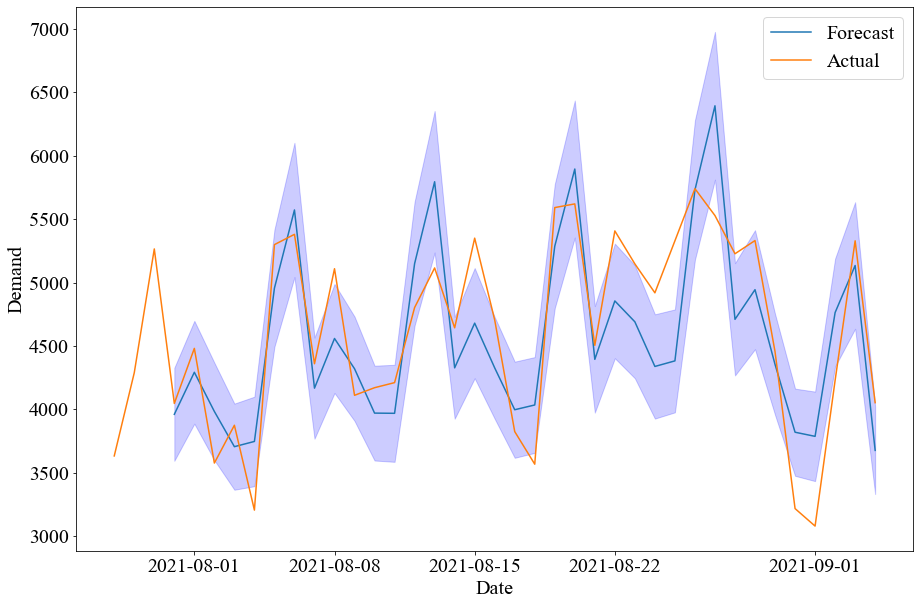

In [31]:
plt.rcParams["figure.figsize"] = (15,10)
plt.plot(forc_dem.index, pred_monte)
plt.fill_between(forc_dem.index, pred_monte+pred_monte_std, pred_monte-pred_monte_std, color='b', alpha=.2)
plt.plot(sum_demand_ser['2021-07-28':'2021-09-04'])

plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend(['Forecast', 'Actual'])
plt.show()

In [32]:
rmse = math.sqrt(mean_squared_error(sum_demand_ser['2021-07-31':'2021-09-04'], pred_monte))
MAPE = mean_absolute_percentage_error(sum_demand_ser['2021-07-31':'2021-09-04'], pred_monte)
print('RMSE: ', rmse)
print('MAPE, %: ', MAPE)

RMSE:  444.68697838532864
MAPE, %:  8.588


## LSTM with only Queries (LSTM only Q.)

In [33]:
def split_sequence(inp, out, n_steps):
	X, y = list(), list()
	for i in range(len(inp)):
		end_ix = i + n_steps
		if end_ix > len(inp)-1:
			break
		seq_x, seq_y = inp[i:end_ix], out[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [48]:
req_name='сапсан билеты'
n_steps = 3

res1_train, res1_test = train_test_split(res_req_df.loc[req_name]['2021-05-12':'2021-09-04'], test_size=0.33, shuffle = False)
scaler_train = MinMaxScaler()
scaler_req = MinMaxScaler()
dem_train_sc=scaler_train.fit_transform(np.array(dem_train).reshape(-1, 1))
dem_test_sc=scaler_train.fit_transform(np.array(dem_test).reshape(-1, 1))
dem_train_sc, dem_test_sc=dem_train_sc.ravel(), dem_test_sc.ravel()

res1_train_sc=scaler_req.fit_transform(np.array(res1_train).reshape(-1, 1))
res1_test_sc=scaler_req.fit_transform(np.array(res1_test).reshape(-1, 1))
res1_train_sc, res1_test_sc=res1_train_sc.ravel(), res1_test_sc.ravel()

train_X, train_Y = split_sequence(res1_train_sc, dem_train_sc, n_steps)
test_X, test_Y = split_sequence(res1_test_sc, dem_test_sc, n_steps)

n_features = 1
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], n_features))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))

In [49]:
def build_model(n_features: int):
    model = Sequential()
    model.add(LSTM(32, activation='tanh', recurrent_activation='sigmoid', recurrent_dropout=0, 
                   unroll=False, use_bias=True, return_sequences = True, input_shape=(n_steps, n_features)))
    model.add(LSTM(32, return_sequences = True))
    model.add(LSTM(32))
    model.add(Dropout(0.9))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

In [50]:
num_epochs=10
model=build_model(n_features)
history=model.fit(train_X, train_Y, epochs=num_epochs, shuffle=False, batch_size=1, verbose=0)

In [55]:
lag=3
pred_Y = model.predict(test_X, verbose=0)
scl_pred_Y=scaler_train.inverse_transform(pred_Y).ravel()

rmse = math.sqrt(mean_squared_error(dem_test.values[lag:], scl_pred_Y))
MAPE = mean_absolute_percentage_error(dem_test.values[lag:], scl_pred_Y)
print('RMSE: ', rmse)
print('MAPE, %: ', MAPE)

RMSE:  347.7223133102365
MAPE, %:  5.823


### LSTM only Q. Monte Carlo

In [56]:
dem_pred=pd.Series(data=scl_pred_Y, index=dem_test.index[lag:])
pred_list=list()
for i in range(1000):
    forc_dem=dem_pred*seas_pred[lag:]*np.random.normal(mu, sigma, len(forc_dem))
    pred_list.append(forc_dem)
pred_monte=np.mean(pred_list, axis=0)
pred_monte_std=np.std(pred_list, axis=0)

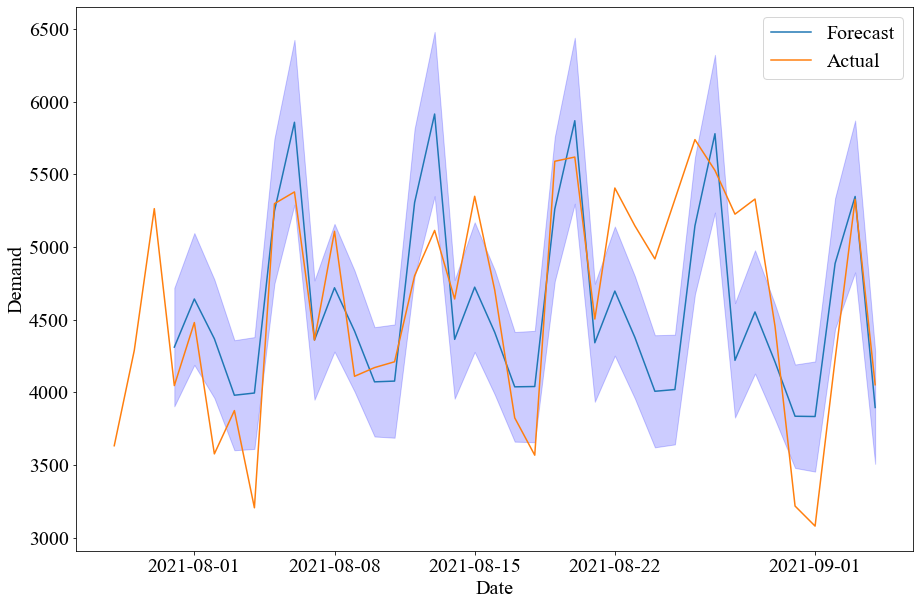

In [60]:
plt.rcParams["figure.figsize"] = (15,10)
plt.plot(forc_dem.index, pred_monte)
plt.fill_between(forc_dem.index, pred_monte+pred_monte_std, pred_monte-pred_monte_std, color='b', alpha=.2)
plt.plot(dem_test.index, sum_demand_ser['2021-07-28':'2021-09-04'])

plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend(['Forecast', 'Actual'])
plt.show()

In [58]:
rmse = math.sqrt(mean_squared_error(sum_demand_ser['2021-07-31':'2021-09-04'], pred_monte))
MAPE = mean_absolute_percentage_error(sum_demand_ser['2021-07-31':'2021-09-04'], pred_monte)
print('RMSE: ', rmse)
print('MAPE, %: ', MAPE)

RMSE:  550.8190136647964
MAPE, %:  10.054


## LSTM without the predictor (LSTM W.)

In [66]:
n_steps=3

train_X, train_Y = split_sequence(dem_train_sc, dem_train_sc, n_steps)
test_X, test_Y = split_sequence(dem_test_sc, dem_test_sc, n_steps)

n_features = 1
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], n_features))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))

In [147]:
def build_model(n_features: int):
    model = Sequential()
    model.add(LSTM(132, activation='tanh', recurrent_activation='sigmoid', recurrent_dropout=0, 
                   unroll=False, use_bias=True, return_sequences = True, input_shape=(n_steps, n_features)))
    model.add(LSTM(132, return_sequences = True))
    model.add(Dropout(0.5))
    model.add(LSTM(132))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

In [148]:
num_epochs=50
model=build_model(n_features)
history=model.fit(train_X, train_Y, epochs=num_epochs, shuffle=False, batch_size=1, verbose=0)

In [150]:
rmse = math.sqrt(mean_squared_error(dem_test.values[lag:], scl_pred_Y))
MAPE = mean_absolute_percentage_error(dem_test.values[lag:], scl_pred_Y)
print('RMSE: ', rmse)
print('MAPE, %: ', MAPE)

RMSE:  154.5392085379526
MAPE, %:  2.701


### LSTM W. Monte Carlo

In [151]:
dem_pred=pd.Series(data=scl_pred_Y, index=dem_test.index[lag:])
pred_list=list()
for i in range(1000):
    forc_dem=dem_pred*seas_pred[lag:]*np.random.normal(mu, sigma, len(forc_dem))
    pred_list.append(forc_dem)
pred_monte=np.mean(pred_list, axis=0)
pred_monte_std=np.std(pred_list, axis=0)

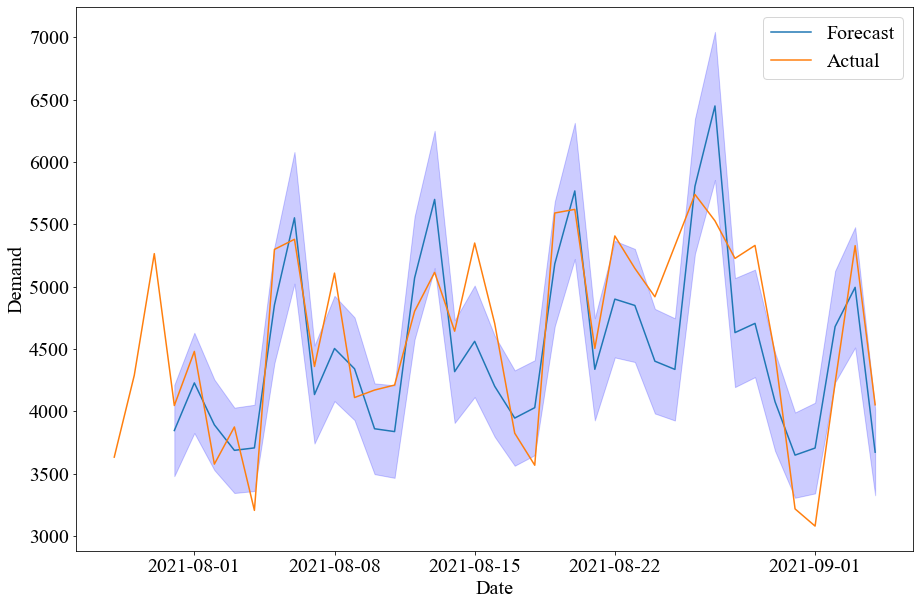

In [155]:
plt.rcParams["figure.figsize"] = (15,10)
plt.plot(forc_dem.index, pred_monte)
plt.fill_between(forc_dem.index, pred_monte+pred_monte_std, pred_monte-pred_monte_std, color='b', alpha=.2)
plt.plot(dem_test.index, sum_demand_ser['2021-07-28':'2021-09-04'])

plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend(['Forecast', 'Actual'])
plt.show()

In [153]:
rmse = math.sqrt(mean_squared_error(sum_demand_ser['2021-07-31':'2021-09-04'], pred_monte))
MAPE = mean_absolute_percentage_error(sum_demand_ser['2021-07-31':'2021-09-04'], pred_monte)
print('RMSE: ', rmse)
print('MAPE, %: ', MAPE)

RMSE:  460.5966297673988
MAPE, %:  8.981


# ARIMA-based models

## Choice of d and q Model Components

Series stationarity test
<br><font color=red>H0:</font> The time series has a unit root, it is non-stationary;
<br><font color=red>H1:</font> The time series does not have a unit root, it is stationary.

In [100]:
adfuller(result.trend['2021-05-12':'2021-09-04'].values.squeeze())

(-2.418655292094193,
 0.13654016716871764,
 11,
 104,
 {'1%': -3.4948504603223145,
  '5%': -2.889758398668639,
  '10%': -2.5818220155325444},
 1175.3925472880892)

The <font color=red>H0</font> can't be rejected.

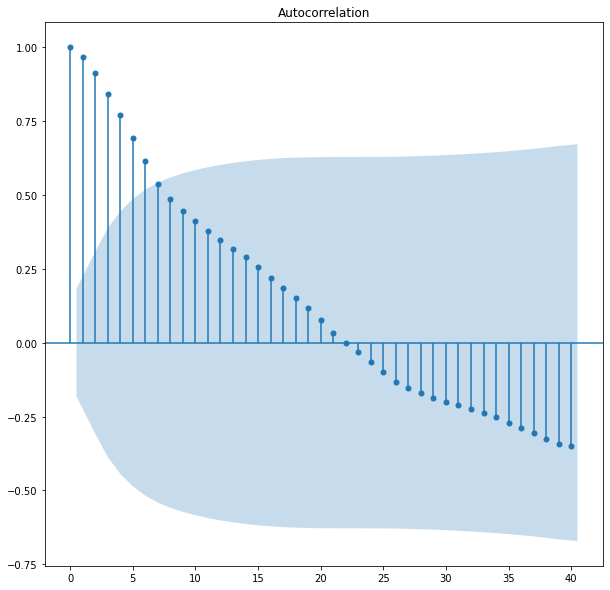

In [41]:
sm.graphics.tsa.plot_acf(result.trend['2021-05-12':'2021-09-04'].values.squeeze(), lags=40)
plt.show()

In [42]:
adfuller(result.trend['2021-05-12':'2021-09-04'].diff().dropna().values.squeeze())

(-2.1680298222346153,
 0.21805266943513119,
 7,
 107,
 {'1%': -3.492995948509562,
  '5%': -2.888954648057252,
  '10%': -2.58139291903223},
 1167.491344486161)

The <font color=red>H0</font> can't be rejected.

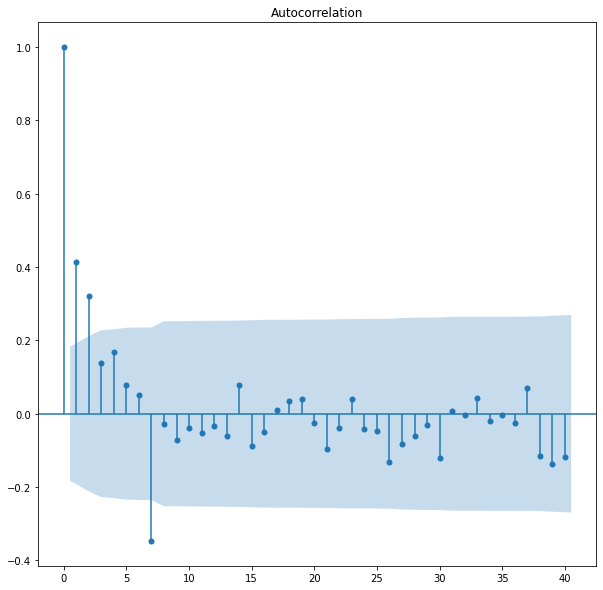

In [43]:
sm.graphics.tsa.plot_acf(result.trend['2021-05-12':'2021-09-04'].diff().dropna().values.squeeze(), lags=40)
plt.show()

In [157]:
adfuller(result.trend['2021-05-12':'2021-09-04'].diff().diff().dropna().values.squeeze())

(-5.1291228986980295,
 1.2246861464888075e-05,
 9,
 104,
 {'1%': -3.4948504603223145,
  '5%': -2.889758398668639,
  '10%': -2.5818220155325444},
 1158.713334235899)

The <font color=red>H0</font> can be rejected with a confidence level of 0.99.

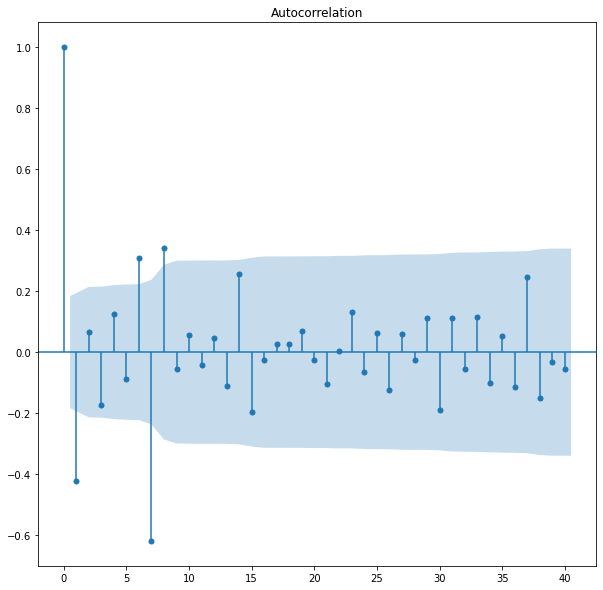

In [45]:
sm.graphics.tsa.plot_acf(result.trend['2021-05-12':'2021-09-04'].diff().diff().dropna().values.squeeze(), lags=40)
plt.show()

Presumably d=2, q=0

## Choice of p сomponent

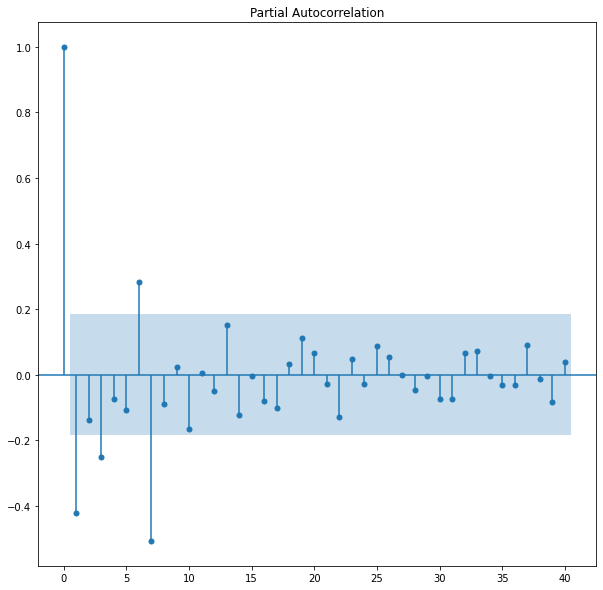

In [48]:
sm.graphics.tsa.plot_pacf(result.trend['2021-05-12':'2021-09-04'].diff().diff().dropna().values.squeeze(), lags=40, method="ywm")
plt.show()

Presumably p=7

## ARIMA model

### Forecast for 39 days

In [163]:
trend_train, trend_test = train_test_split(result.trend['2021-05-12':'2021-09-04'], test_size=0.33, shuffle = False)

scaler_train = MinMaxScaler()
trend_train_sc=scaler_train.fit_transform(np.array(trend_train).reshape(-1, 1))
trend_train_sc=trend_train_sc.ravel()

p, d, q = 7, 2, 0
model = sm.tsa.arima.ARIMA(trend_train_sc, order=(p,d,q))
model_fit = model.fit(method_kwargs={"warn_convergence": False})
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   77
Model:                 ARIMA(7, 2, 0)   Log Likelihood                  94.673
Date:                Mon, 25 Jul 2022   AIC                           -173.346
Time:                        13:51:14   BIC                           -154.806
Sample:                             0   HQIC                          -165.943
                                 - 77                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4124      0.132     -3.123      0.002      -0.671      -0.154
ar.L2         -0.2067      0.122     -1.698      0.090      -0.445       0.032
ar.L3         -0.3171      0.124     -2.561      0.0

In [ ]:
forc=scaler_train.inverse_transform(model_fit.forecast(len(trend_test)).reshape(-1, 1)).ravel()

In [165]:
rmse = math.sqrt(mean_squared_error(trend_test.values, forc))
MAPE = mean_absolute_percentage_error(trend_test.values, forc)
print('RMSE: ', rmse)
print('MAPE, %: ', MAPE)

RMSE:  415.942078207027
MAPE, %:  7.025


### Forecast for 39 days Monte Carlo

In [166]:
pred_list=list()
for i in range(1000):
    forc_dem=forc*seas_pred*np.random.normal(mu, sigma, len(seas_pred))
    pred_list.append(forc_dem)
pred_monte=np.mean(pred_list, axis=0)
pred_monte_std=np.std(pred_list, axis=0)

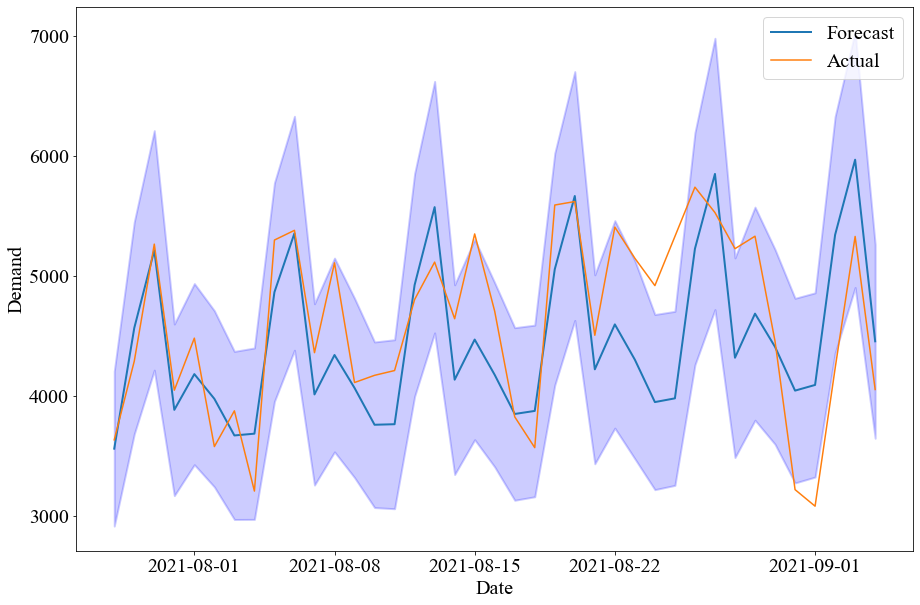

In [167]:
plt.rcParams['font.size'] = '20'
plt.rcParams['font.fantasy'] = 'Times New Roman'
plt.rcParams['font.family'] = 'fantasy'
plt.rcParams["figure.figsize"] = (15,10)
plt.plot(trend_test.index, pred_monte, linewidth=2)
plt.fill_between(trend_test.index, pred_monte+1.96*pred_monte_std, pred_monte-1.96*pred_monte_std, color='b', linewidth=2, alpha=.2)
plt.plot(trend_test.index, sum_demand_ser['2021-07-28':'2021-09-04'])

plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend(['Forecast', 'Actual'])

In [168]:
rmse = math.sqrt(mean_squared_error(sum_demand_ser['2021-07-28':'2021-09-04'], pred_monte))
MAPE = mean_absolute_percentage_error(sum_demand_ser['2021-07-28':'2021-09-04'], pred_monte)
print('RMSE: ', rmse)
print('MAPE, %: ', MAPE)

RMSE:  581.2435225946247
MAPE, %:  10.5


### Forecast for 1 day

In [194]:
def fit_ARIMA(data: np.array, p, d, q):
    model = sm.tsa.arima.ARIMA(data, order=(p,d,q))
    model_fit = model.fit(start_params=None, method_kwargs={"warn_convergence": False})
    return model_fit

def rot_errors(data_len: int, model_fit, mu, sigma)->list:
    pred_list=list()
    for i in range(1000):
        forc_dem=model_fit.forecast()*np.random.normal(mu, sigma, data_len)
        pred_list.append(forc_dem[0])
    pred_monte=np.mean(pred_list)
    pred_monte_std=np.std(pred_list)
    return pred_monte, pred_monte_std

In [195]:
roll_train_list=list(trend_train.values)
pred_mean_list, pred_std_list = list(), list()
for val in trend_test.values:
    roll_train_list.append(val)
    model_fit=fit_ARIMA(roll_train_list, p, d, q)
    pred_monte, pred_monte_std=rot_errors(1, model_fit, mu, sigma)
    pred_mean_list.append(pred_monte), pred_std_list.append(pred_monte_std)
pred_mean_list=np.array(pred_mean_list[:-1])*seas_pred[1:]
pred_std_list=np.array(pred_std_list[:-1])

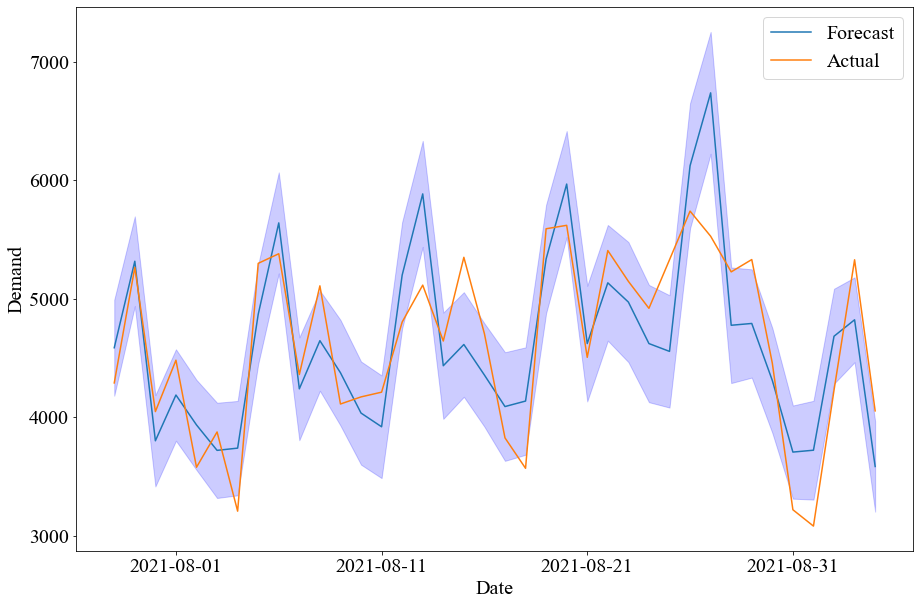

In [196]:
plt.rcParams['font.size'] = '20'
plt.rcParams['font.fantasy'] = 'Times New Roman'
plt.rcParams['font.family'] = 'fantasy'
plt.rcParams["figure.figsize"] = (15,10)
fig, ax = plt.subplots()
ax.plot(trend_test.index[1:], pred_mean_list)
ax.fill_between(trend_test.index[1:], pred_mean_list+pred_std_list, pred_mean_list-pred_std_list, color='b', alpha=.2)
ax.plot(trend_test.index[1:], sum_demand_ser['2021-07-29':'2021-09-04'])

ax.set_xlabel('Date')
ax.set_ylabel('Demand')
ax.legend(['Forecast', 'Actual'])
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
plt.show()

In [197]:
rmse = math.sqrt(mean_squared_error(sum_demand_ser['2021-07-29':'2021-09-04'], pred_mean_list))
MAPE = mean_absolute_percentage_error(sum_demand_ser['2021-07-29':'2021-09-04'], pred_mean_list)
print('RMSE: ', rmse)
print('MAPE, %: ', MAPE)

RMSE:  448.23731030835876
MAPE, %:  8.558


## ARIMAX model

### Forecast for 39 days

In [198]:
def fit_SARIMAX(data: np.array, exogen_data: np.array, p, d, q):
    model = sm.tsa.statespace.SARIMAX(data, exog=exogen_data, order=(p,d,q))
    model_fit = model.fit(method_kwargs={"warn_convergence": False})
    return model_fit

In [199]:
req_name='сапсан билеты'
trend_train, trend_test = train_test_split(result.trend['2021-05-12':'2021-09-04'], test_size=0.33, shuffle = False)
res1_train, res1_test = train_test_split(res_req_df.loc[req_name]['2021-05-12':'2021-09-04'], test_size=0.33, shuffle = False)

In [200]:
scaler_res = MinMaxScaler(feature_range = (min(trend_train.values), max(trend_train.values)))
res1_train_sc=scaler_res.fit_transform(np.array(res1_train.values).reshape(-1, 1))
res1_train_sc=res1_train_sc.ravel()

p, d, q = 7, 2, 0
model_fit=fit_SARIMAX(trend_train.values, res1_train_sc, p, d, q)

In [201]:
res1_test_sc=scaler_res.fit_transform(np.array(res1_test.values).reshape(-1, 1))
res1_test_sc=res1_test_sc.ravel()

pred_list=list()
for val in np.array(res1_test_sc):
    pred_list.append(model_fit.forecast(exog=val))

In [202]:
mu, sigma = result.resid['2021-05-12':'2021-09-04'].mean(), result.resid['2021-05-12':'2021-09-04'].std()
forc_list=np.array(pred_list).ravel()
pred_list=list()
for i in range(1000):
    forc_dem=forc_list*seas_pred*np.random.normal(mu, sigma, len(seas_pred))
    pred_list.append(forc_dem)
pred_monte=np.mean(pred_list, axis=0)
pred_monte_std=np.std(pred_list, axis=0)

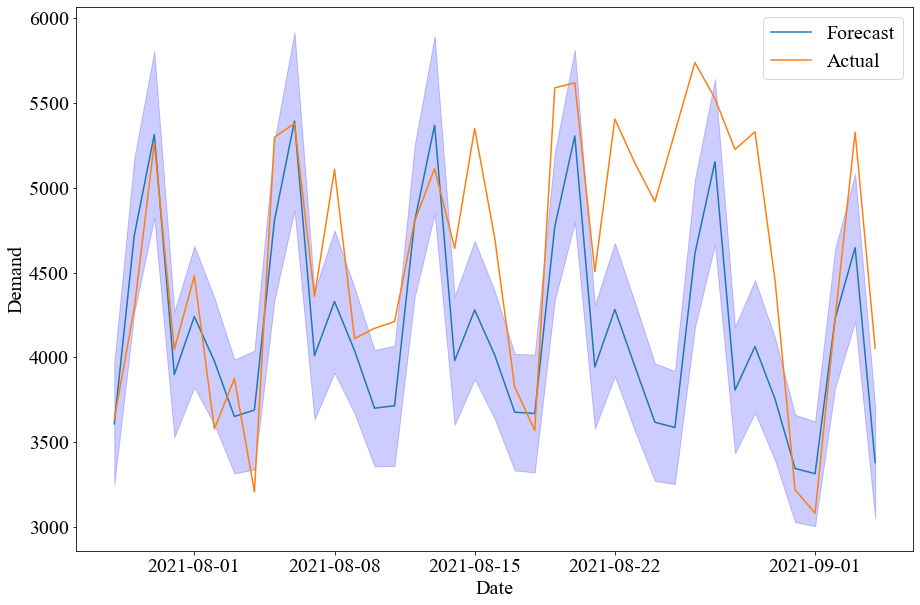

In [205]:
plt.rcParams["figure.figsize"] = (15,10)
plt.plot(trend_test.index, pred_monte)
plt.fill_between(trend_test.index, pred_monte+pred_monte_std, pred_monte-pred_monte_std, color='b', alpha=.2)
plt.plot(trend_test.index, sum_demand_ser['2021-07-28':'2021-09-04'])

plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend(['Forecast', 'Actual'])
plt.show()

In [212]:
rmse = math.sqrt(mean_squared_error(trend_test.values, pred_monte))
MAPE = mean_absolute_percentage_error(trend_test.values, pred_monte)
print('RMSE: ', rmse)
print('MAPE, %: ', MAPE)

RMSE:  797.1164948030165
MAPE, %:  14.865


### Forecast for 1 day

In [206]:
def rot_errors_SARIMAX(data_len: int, model_fit, mu, sigma, val)->list:
    pred_list=list()
    for i in range(1000):
        forc_dem=model_fit.forecast(exog=val)*np.random.normal(mu, sigma, data_len)
        pred_list.append(forc_dem[0])
    pred_monte=np.mean(pred_list)
    pred_monte_std=np.std(pred_list)
    return pred_monte, pred_monte_std

In [207]:
roll_train_list=list(trend_train.values)
roll_ex_list=list(res1_train_sc)
pred_mean_list, pred_std_list = list(), list()
for trend_val, res_val in zip(trend_test.values, res1_test_sc):
    roll_train_list.append(trend_val)
    roll_ex_list.append(res_val)
    model_fit=fit_SARIMAX(roll_train_list, roll_ex_list, p, d, q)
    pred_monte, pred_monte_std=rot_errors_SARIMAX(1, model_fit, mu, sigma, res_val)
    pred_mean_list.append(pred_monte), pred_std_list.append(pred_monte_std)
pred_mean_list=np.array(pred_mean_list[:-1])*seas_pred[1:]
pred_std_list=np.array(pred_std_list[:-1])

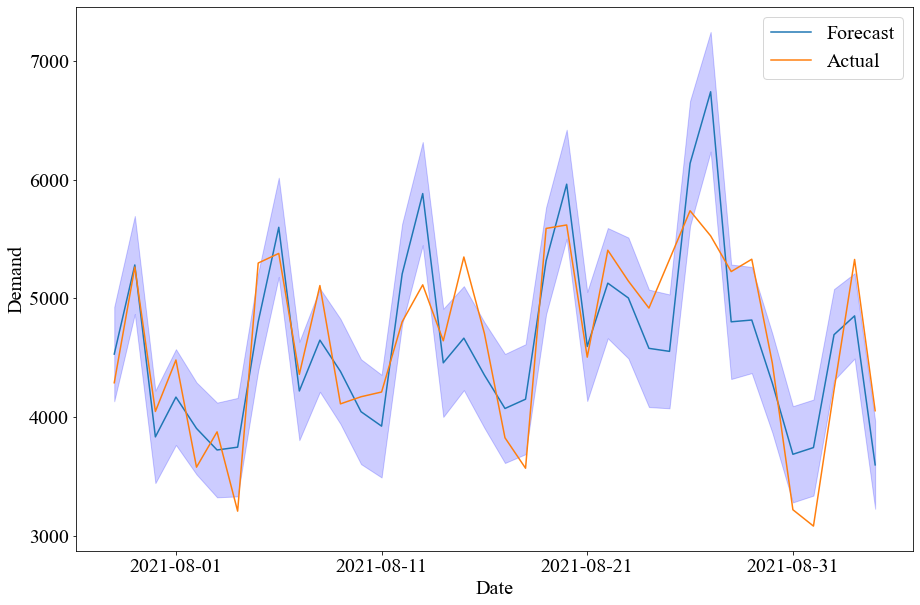

In [210]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (15,10)
ax.plot(trend_test.index[1:], pred_mean_list)
ax.fill_between(trend_test.index[1:], pred_mean_list+pred_std_list, pred_mean_list-pred_std_list, color='b', alpha=.2)
ax.plot(trend_test.index[1:], sum_demand_ser['2021-07-29':'2021-09-04'])

ax.set_xlabel('Date')
ax.set_ylabel('Demand')
ax.legend(['Forecast', 'Actual'])
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
plt.show()

In [218]:
rmse = math.sqrt(mean_squared_error(sum_demand_ser['2021-07-29':'2021-09-04'], pred_mean_list))
MAPE = mean_absolute_percentage_error(sum_demand_ser['2021-07-29':'2021-09-04'], pred_mean_list)
print('RMSE: ', rmse)
print('MAPE, %: ', MAPE)

RMSE:  445.9684717004085
MAPE, %:  8.432


## Choice of P, D, Q, m Model Components

Series stationarity test
<br><font color=red>H0:</font> The time series has a unit root, it is non-stationary;
<br><font color=red>H1:</font> The time series does not have a unit root, it is stationary.

In [212]:
adfuller(result.seasonal['2021-05-12':'2021-09-04'].values.squeeze())

(-2019114294407217.2,
 0.0,
 8,
 107,
 {'1%': -3.492995948509562,
  '5%': -2.888954648057252,
  '10%': -2.58139291903223},
 -7240.117906891209)

The <font color=red>H0</font> can be rejected.

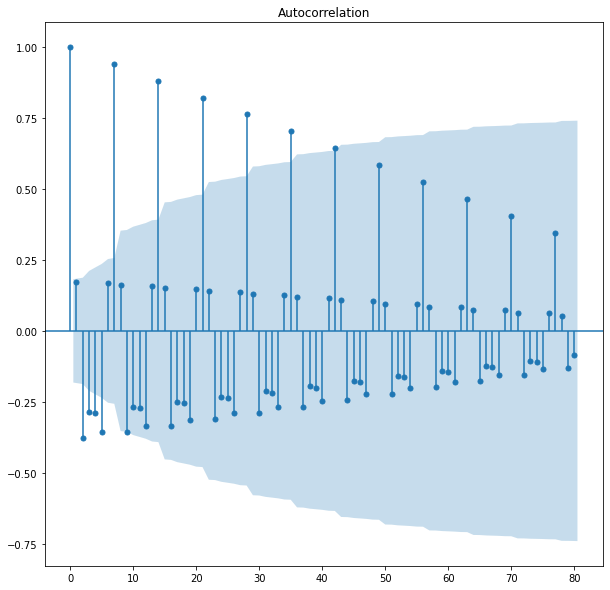

In [73]:
sm.graphics.tsa.plot_acf(result.seasonal['2021-05-12':'2021-09-04'].values.squeeze(), lags=80)
plt.show()

Presumably D=0, Q=1

## Choice of P, m сomponents

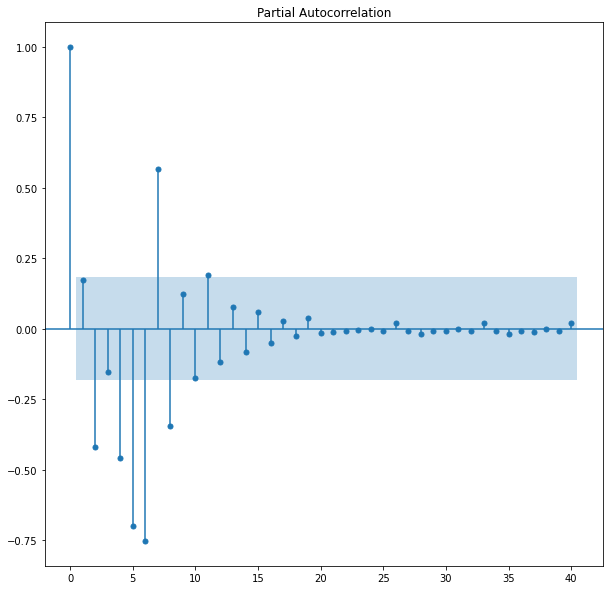

In [76]:
sm.graphics.tsa.plot_pacf(result.seasonal['2021-05-12':'2021-09-04'].values.squeeze(), lags=40, method="ywm")
plt.show()

Presumably P=7, m=4

## SARIMA model

In [215]:
def fit_SARIMA(data: np.array, p, d, q, P, D, Q, m, start_params):
    model = sm.tsa.statespace.SARIMAX(data, order=(p,d,q), season_order=(P,D,Q,m))
    model_fit = model.fit(disp=False, maxiter=400, start_params= start_params)
    return model_fit

In [227]:
trend_train, trend_test = train_test_split(result.trend['2021-05-12':'2021-09-04'], test_size=0.33, shuffle = False)
seas_train, seas_test = train_test_split(result.seasonal['2021-05-12':'2021-09-04'], test_size=0.33, shuffle = False)
train_data=trend_train*seas_train
train_data=train_data.asfreq(freq='D')
test_data=trend_test*seas_test

scaler_train = MinMaxScaler()
train_data_sc=scaler_train.fit_transform(np.array(train_data).reshape(-1, 1))
train_data_sc=train_data_sc.ravel()
train_data_sc=pd.Series(data=train_data_sc, index=train_data.index)

test_data_sc=scaler_train.fit_transform(np.array(test_data).reshape(-1, 1))
test_data_sc=test_data_sc.ravel()
test_data_sc=pd.Series(data=test_data_sc, index=test_data.index)

In [228]:
P, D, Q, m = 7, 0, 1, 4
p, d, q = 7, 2, 0

start_params=np.zeros(12)+0.0001
model_fit=fit_SARIMA(train_data_sc, p, d, q, P, D, Q, m, start_params)

In [ ]:
pred_list=scaler_train.inverse_transform(model_fit.forecast(len(test_data)).values.reshape(-1, 1)).ravel()
pred_ser=pd.Series(data=pred_list, index=model_fit.forecast(len(test_data)).index)

In [232]:
rmse = math.sqrt(mean_squared_error(test_data.values, pred_ser))
MAPE = mean_absolute_percentage_error(test_data.values, pred_ser)
print('RMSE: ', rmse)
print('MAPE, %: ', MAPE)

RMSE:  1174.9395164106943
MAPE, %:  23.811


### Forecast for 39 days Monte Carlo

In [233]:
def rot_SARIMA(train_data: pd.Series, test_data: pd.Series, k, p, d, q, P, D, Q, m, mu, sigma, start_params, scaler):
    all_preds_list=list()
    for i in range(k):
        model_fit=fit_SARIMA(train_data, p, d, q, P, D, Q, m, start_params)
        pred_list = scaler.inverse_transform(model_fit.forecast(len(test_data)).values.reshape(-1, 1)).ravel()*np.random.normal(mu, sigma, len(test_data))
        all_preds_list.append(pred_list)
    mean_preds=np.mean(all_preds_list, axis=0)
    std_preds=np.std(all_preds_list, axis=0)
    idx=model_fit.forecast(len(test_data)).index
    mean_preds=pd.Series(data=mean_preds, index=idx)
    std_preds=pd.Series(data=std_preds, index=idx)
    return mean_preds, std_preds, all_preds_list

In [235]:
P, D, Q, m = 7, 0, 1, 4
p, d, q = 7, 2, 1
k=1000
start_params=np.zeros(12)+0.0001
mean_preds, std_preds, all_preds_list=rot_SARIMA(train_data_sc, trend_test, k, p, d, q, P, D, Q, m, mu, sigma, start_params, scaler_train)

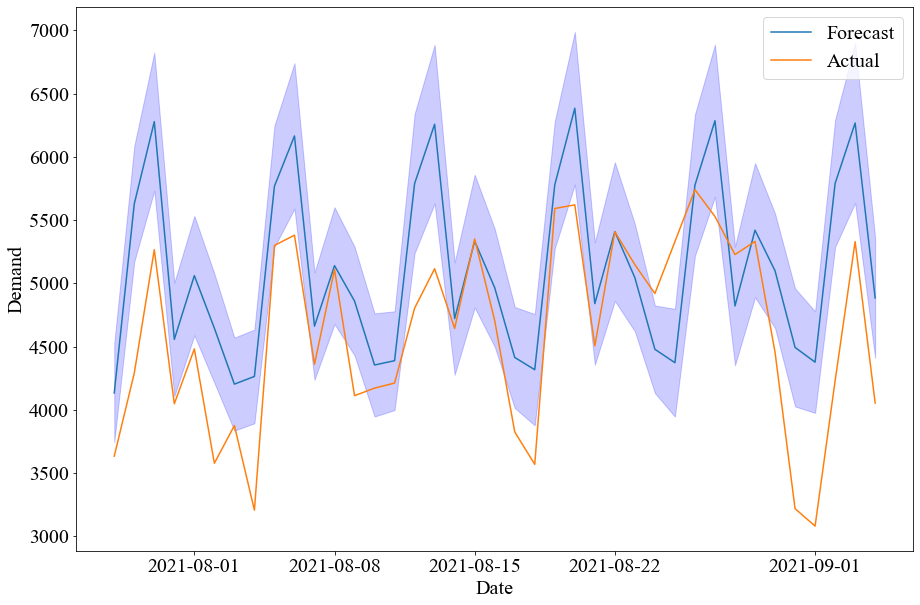

In [236]:
plt.rcParams["figure.figsize"] = (15,10)
plt.plot(mean_preds.index, mean_preds)
plt.fill_between(mean_preds.index, mean_preds+std_preds, mean_preds-std_preds, color='b', alpha=.2)
plt.plot(mean_preds.index, sum_demand_ser['2021-07-28':'2021-09-04'])

plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend(['Forecast', 'Actual'])
plt.show()

In [237]:
rmse = math.sqrt(mean_squared_error(sum_demand_ser['2021-07-28':'2021-09-04'], mean_preds))
MAPE = mean_absolute_percentage_error(sum_demand_ser['2021-07-28':'2021-09-04'], mean_preds)
print('RMSE: ', rmse)
print('MAPE, %: ', MAPE)

RMSE:  736.7222577273659
MAPE, %:  14.198


### Forecast for 1 day Monte Carlo

In [239]:
def rot_errors(data_len: int, model_fit, mu, sigma, scaler)->list:
    pred_list=list()
    for i in range(1000):
        forc_dem=scaler.inverse_transform(model_fit.forecast().reshape(-1, 1)).ravel()*np.random.normal(mu, sigma, data_len)
        pred_list.append(forc_dem[0])
    pred_monte=np.mean(pred_list)
    pred_monte_std=np.std(pred_list)
    return pred_monte, pred_monte_std

In [240]:
start_params=np.zeros(12)+0.0001

roll_train_list=list(train_data_sc.values)
pred_mean_list, pred_std_list = list(), list()
for val in test_data_sc.values:
    roll_train_list.append(val)
    model_fit=fit_SARIMA(roll_train_list, p, d, q, P, D, Q, m, start_params)
    pred_monte, pred_monte_std=rot_errors(1, model_fit, mu, sigma, scaler_train)
    pred_mean_list.append(pred_monte), pred_std_list.append(pred_monte_std)
pred_mean_list=np.array(pred_mean_list[:-1])
pred_std_list=np.array(pred_std_list[:-1])

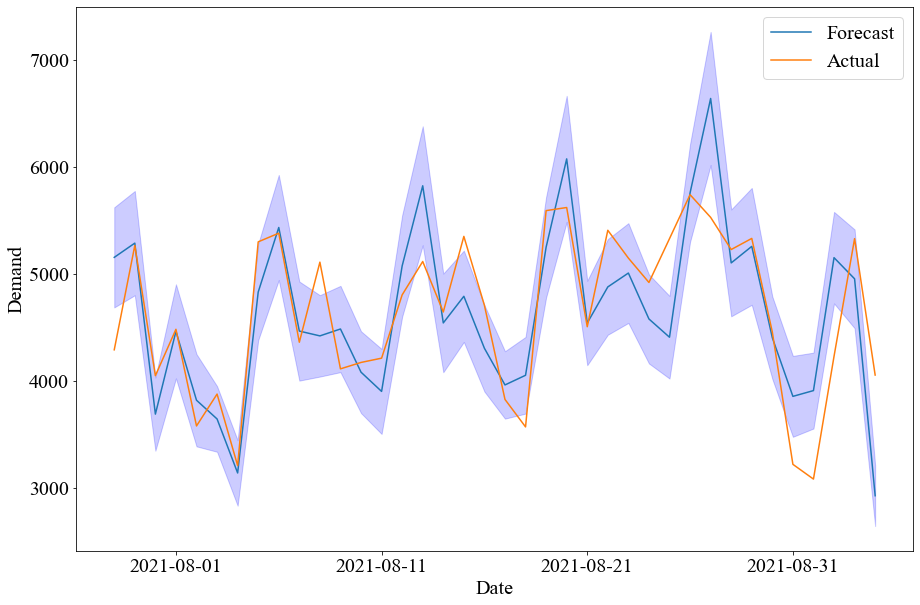

In [242]:
fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (15,10)
ax.plot(test_data.index[1:], pred_mean_list)
ax.fill_between(test_data.index[1:], pred_mean_list+pred_std_list, pred_mean_list-pred_std_list, color='b', alpha=.2)
ax.plot(test_data.index[1:], sum_demand_ser['2021-07-29':'2021-09-04'])

ax.set_xlabel('Date')
ax.set_ylabel('Demand')
ax.legend(['Forecast', 'Actual'])
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
plt.show()

In [236]:
rmse = math.sqrt(mean_squared_error(sum_demand_ser['2021-07-29':'2021-09-04'], pred_mean_list))
MAPE = mean_absolute_percentage_error(sum_demand_ser['2021-07-29':'2021-09-04'], pred_mean_list)
print('RMSE: ', rmse)
print('MAPE, %: ', MAPE)

RMSE:  484.6062339225973
MAPE, %:  8.515


## SARIMAX model

In [243]:
def fit_SARIMA(data: np.array, ex_data: pd.Series, p, d, q, P, D, Q, m, start_params):
    model = sm.tsa.statespace.SARIMAX(data, order=(p,d,q), exog=ex_data, season_order=(P,D,Q,m))
    model_fit = model.fit(disp=False, maxiter=400, start_params= start_params)
    return model_fit

In [244]:
def rot_SARIMA(train_data: pd.Series, test_data: pd.Series, ex_train_data: pd.Series, ex_test_data: pd.Series, k, p, d, q, P, D, Q, m, mu, sigma, start_params, scaler):
    all_preds_list=list()
    for i in range(k):
        pred_list=list()
        model_fit=fit_SARIMA(train_data, ex_train_data, p, d, q, P, D, Q, m, start_params)
        for val in ex_test_data:
            pred_list.append(model_fit.forecast(exog=val)[0])
        pred_list = pred_list*np.random.normal(mu, sigma, len(test_data))
        all_preds_list.append(pred_list)
    mean_preds=np.mean(all_preds_list, axis=0)
    std_preds=np.std(all_preds_list, axis=0)
    return mean_preds, std_preds, all_preds_list

In [245]:
scaler_res = MinMaxScaler(feature_range = (min(train_data.values), max(train_data.values)))
# For Q*S
#res1_train_sc=scaler_res.fit_transform(np.array(res1_train.values*seas_train/max(*seas_test)).reshape(-1, 1))
# For Q
res1_train_sc=scaler_res.fit_transform(np.array(res1_train.values).reshape(-1, 1))
res1_train_sc=res1_train_sc.ravel()

# For Q*S
#res1_test_sc=scaler_res.fit_transform(np.array(res1_test.values*seas_test/max(*seas_test)).reshape(-1, 1))
# For Q
res1_test_sc=scaler_res.fit_transform(np.array(res1_test.values).reshape(-1, 1))
res1_test_sc=res1_test_sc.ravel()

### Forecast for 39 days Monte Carlo (Q)

In [248]:
P, D, Q, m = 7, 0, 1, 4
p, d, q = 7, 2, 0
start_params=np.zeros(12)+0.0001
model_fit=fit_SARIMA(train_data.values, res1_train_sc, p, d, q, P, D, Q, m, start_params)
pred_list=list()
for val in np.array(res1_test_sc):
    pred_list.append(model_fit.forecast(exog=val)[0])

In [250]:
k=1000
mean_preds, std_preds, all_preds_list=rot_SARIMA(train_data.values, test_data.values, res1_train_sc, res1_test_sc, k, p, d, q, P, D, Q, m, mu, sigma, start_params, scaler_train)

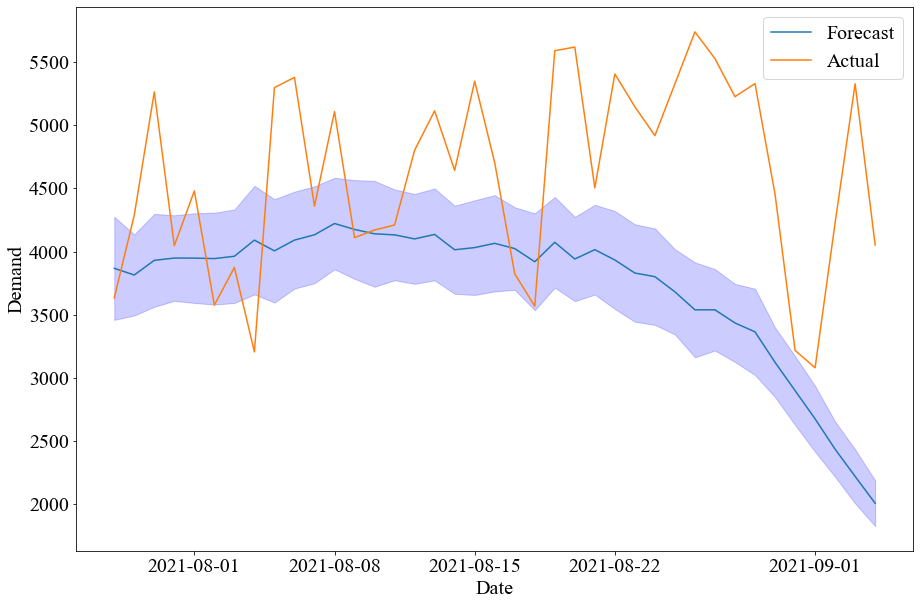

In [253]:
plt.rcParams["figure.figsize"] = (15,10)
plt.plot(test_data.index, mean_preds)
plt.fill_between(test_data.index, mean_preds+std_preds, mean_preds-std_preds, color='b', alpha=.2)
plt.plot(test_data.index, sum_demand_ser['2021-07-28':'2021-09-04'])

plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend(['Forecast', 'Actual'])
plt.show()

In [246]:
rmse = math.sqrt(mean_squared_error(sum_demand_ser['2021-07-28':'2021-09-04'], mean_preds))
MAPE = mean_absolute_percentage_error(sum_demand_ser['2021-07-28':'2021-09-04'], mean_preds)
print('RMSE: ', rmse)
print('MAPE, %: ', MAPE)

RMSE:  1245.4250393150692
MAPE, %:  20.536


### Forecast for 1 day Monte Carlo (Q)

In [ ]:
def fit_SARIMA(data: np.array, ex_data: pd.Series, p, d, q, P, D, Q, m, start_params):
    model = sm.tsa.statespace.SARIMAX(data, order=(p,d,q), exog=ex_data, season_order=(P,D,Q,m), initialization='approximate_diffuse')
    model_fit = model.fit(disp=False, maxiter=400, start_params= start_params)
    return model_fit

In [259]:
def rot_SARIMA(train_data: pd.Series, test_data: pd.Series, ex_train_data: pd.Series, ex_test_data: pd.Series, k, p, d, q, P, D, Q, m, mu, sigma, start_params):
    all_preds_list=list()
    for i in range(k):
        pred_list=list()
        model_fit=fit_SARIMA(train_data, ex_train_data, p, d, q, P, D, Q, m, start_params)
        for val in np.array(ex_test_data, dtype=float):
            pred_list.append(model_fit.forecast(exog=val)[0])
        pred_list = pred_list*np.random.normal(mu, sigma, len(ex_test_data))
        all_preds_list.append(pred_list)
    mean_preds=np.mean(all_preds_list, axis=0)
    std_preds=np.std(all_preds_list, axis=0)
    return mean_preds, std_preds, all_preds_list

In [260]:
rolling_list=list(train_data.values)
res1_test_sc=list(res1_test_sc)
rolling_ex_list=list(res1_train_sc)
mean_pr=list()
std_pr=list()
i=0
k=1000

P, D, Q, m = 7, 0, 1, 4
p, d, q = 7, 2, 1
start_params=np.zeros(12)+0.0001

for val in test_data.values:
    rolling_list.append(val)
    rolling_ex_list.append(res1_test_sc.pop(i))
    len_res=len(res1_test_sc)-i
    if len_res==0:
        break
    mean_preds, std_preds, all_preds_list=rot_SARIMA(rolling_list, test_data.values, rolling_ex_list, res1_test_sc, k, p, d, q, P, D, Q, m, mu, sigma, start_params)
    mean_pr.append(mean_preds[0])
    std_pr.append(std_preds[0])
pred_mean_list_sax=np.array(mean_pr)
pred_std_list_sax=np.array(std_pr)

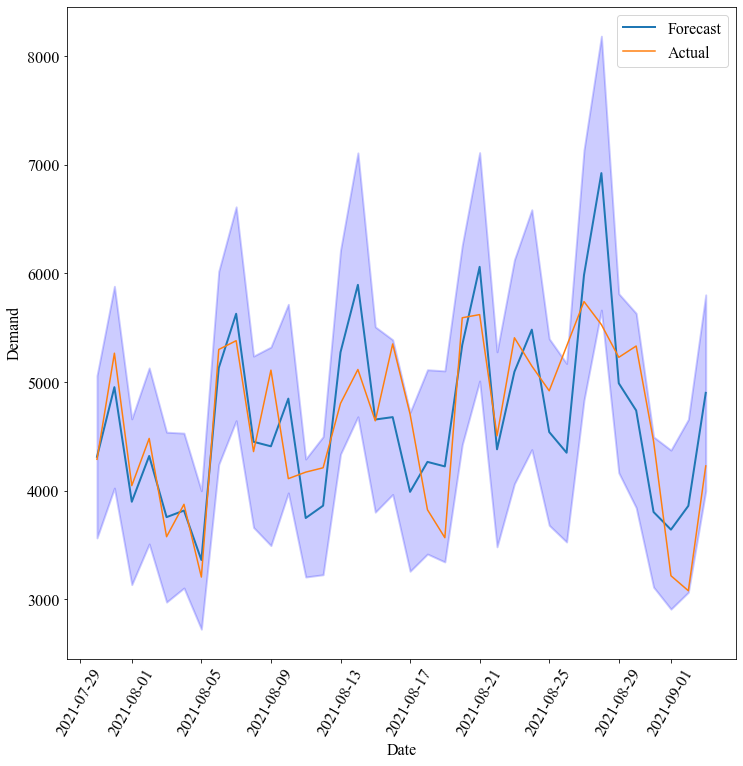

In [121]:
plt.plot(test_data.index[2:-1], pred_mean_list_sax, linewidth=2)
plt.fill_between(test_data.index[2:-1], pred_mean_list_sax+1.96*pred_std_list_sax, pred_mean_list_sax-1.96*pred_std_list_sax, color='b', linewidth=2, alpha=.2)
plt.plot(test_data.index[2:-1], sum_demand_ser['2021-07-29':'2021-09-02'].values)

plt.rcParams['font.size'] = '16'
plt.rcParams['font.fantasy'] = 'Times New Roman'
plt.rcParams['font.family'] = 'fantasy'
plt.rcParams["figure.figsize"] = (12,12)
plt.xlabel('Date')
plt.xticks(rotation = 60)
plt.ylabel('Demand')
plt.legend(['Forecast', 'Actual'])

In [262]:
rmse = math.sqrt(mean_squared_error(sum_demand_ser['2021-07-29':'2021-09-04'], pred_mean_list))
MAPE = mean_absolute_percentage_error(sum_demand_ser['2021-07-29':'2021-09-04'], pred_mean_list)
print('RMSE: ', rmse)
print('MAPE, %: ', MAPE)

RMSE:  441.0
MAPE, %:  8.07
